In [1]:
import gower
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import prince
from kmodes.kmodes import KModes
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance_matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import DBSCAN, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances
from sklearn.tree import DecisionTreeClassifier

In [2]:
df = pd.read_csv("./in-vehicle-coupon-recommendation.csv")

df = df.drop(columns=['car'])
df = df.drop(columns=['toCoupon_GEQ5min'])
df = df.drop(columns=['direction_opp'])
df = df.drop_duplicates()

def value_mapping(df: pd.DataFrame):
    frequency_map = {'never': 0,'less1': 1,'1~3': 2,'4~8': 3,'gt8': 4}
    age_map = {'below21': 0,'21': 1,'26': 2,'31': 3,'36': 4,'41': 5,'46': 6,'50plus': 7}
    income_map = {'Less than $12500': 0,'$12500 - $24999': 1,'$25000 - $37499': 2,'$37500 - $49999': 3,
    '$50000 - $62499': 4,'$62500 - $74999': 5,'$75000 - $87499': 6,'$87500 - $99999': 7,'$100000 or More': 8}
    temperature_map = {30: 0,55: 1,80: 2}

    # CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, Bar
    df['CoffeeHouse'] = df['CoffeeHouse'].map(frequency_map)
    df['CarryAway'] = df['CarryAway'].map(frequency_map)
    df['RestaurantLessThan20'] = df['RestaurantLessThan20'].map(frequency_map)
    df['Restaurant20To50'] = df['Restaurant20To50'].map(frequency_map)
    df['Bar'] = df['Bar'].map(frequency_map)

    #age
    df['age'] = df['age'].map(age_map)

    #income 
    df['income'] = df['income'].map(income_map)

    #temperature
    df['temperature'] = df['temperature'].map(temperature_map)

    return df

for column in df.columns:
    df[column].fillna(df[column].mode()[0], inplace=True)


def value_mapping(df: pd.DataFrame):
    frequency_map = {"never": 0, "less1": 1, "1~3": 2, "4~8": 3, "gt8": 4}
    age_map = {
        "below21": 0,
        "21": 1,
        "26": 2,
        "31": 3,
        "36": 4,
        "41": 5,
        "46": 6,
        "50plus": 7,
    }
    income_map = {
        "Less than $12500": 0,
        "$12500 - $24999": 1,
        "$25000 - $37499": 2,
        "$37500 - $49999": 3,
        "$50000 - $62499": 4,
        "$62500 - $74999": 5,
        "$75000 - $87499": 6,
        "$87500 - $99999": 7,
        "$100000 or More": 8,
    }
    temperature_map = {30: 0, 55: 1, 80: 2}

    # CoffeeHouse, CarryAway, RestaurantLessThan20, Restaurant20To50, Bar
    df["CoffeeHouse"] = df["CoffeeHouse"].map(frequency_map)
    df["CarryAway"] = df["CarryAway"].map(frequency_map)
    df["RestaurantLessThan20"] = df["RestaurantLessThan20"].map(frequency_map)
    df["Restaurant20To50"] = df["Restaurant20To50"].map(frequency_map)
    df["Bar"] = df["Bar"].map(frequency_map)

    # age
    df["age"] = df["age"].map(age_map)

    # income
    df["income"] = df["income"].map(income_map)

    # temperature
    df["temperature"] = df["temperature"].map(temperature_map)

    return df


df = value_mapping(df)

from sklearn.preprocessing import OrdinalEncoder

# Assuming df is your DataFrame
# df = pd.read_csv('your_data.csv')

# Columns for ordinal encoding
ordinal_cols = [
    "destination",
    "weather",
    "time",
    "expiration",
    "maritalStatus",
    "education",
]

# Define the specific ordering for ordinal columns
ordinal_ordering = {
    "destination": ["No Urgent Place", "Home", "Work"],
    "weather": ["Sunny", "Rainy", "Snowy"],
    "time": ["7AM", "10AM", "2PM", "6PM", "10PM"],
    "expiration": ["2h", "1d"],
    "maritalStatus": [
        "Single",
        "Unmarried partner",
        "Married partner",
        "Divorced",
        "Widowed",
    ],
    "education": [
        "Some High School",
        "High School Graduate",
        "Some college - no degree",
        "Associates degree",
        "Bachelors degree",
        "Graduate degree (Masters or Doctorate)",
    ],
}

# Ordinal encoding
ordinal_encoder = OrdinalEncoder(
    categories=[ordinal_ordering[col] for col in ordinal_cols]
)
df[ordinal_cols] = ordinal_encoder.fit_transform(df[ordinal_cols])

# Identify columns to be one-hot encoded (excluding already binary or ordinal encoded columns)
columns_to_encode = df.columns.drop(
    ordinal_cols
    + [
        "temperature",
        "age",
        "has_children",
        "income",
        "Bar",
        "CoffeeHouse",
        "CarryAway",
        "RestaurantLessThan20",
        "Restaurant20To50",
        "toCoupon_GEQ15min",
        "toCoupon_GEQ25min",
        "direction_same",
        "Y",
    ]
)  # Add any other columns to exclude

# One-hot encoding for the non-binary categorical columns
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=int)

# df now contains your processed data

X = df.drop("Y", axis=1)
y = df["Y"]

mca = prince.MCA(n_components=2, random_state=42)
X_mca = mca.fit_transform(X)




In [3]:


#The silhouette score ranges from -1 to 1. A high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
def gower_silhouette_score(X, labels):
    # Compute the Gower distance matrix
    gower_dist_matrix = gower.gower_matrix(X)

    # Initialize variables to store the intra and nearest-cluster distances
    a = np.zeros(X.shape[0])
    b = np.zeros(X.shape[0])

    # Calculate the average intra-cluster distance (a) and the average nearest-cluster distance (b)
    for i in range(X.shape[0]):
        # Same cluster mask
        same_cluster_mask = (labels == labels[i])
        
        # Different cluster mask
        different_cluster_mask = ~same_cluster_mask

        # Intra-cluster distances (a)
        a[i] = np.mean(gower_dist_matrix[i][same_cluster_mask])

        # Nearest-cluster distances (b)
        b[i] = np.min([np.mean(gower_dist_matrix[i][labels == label]) 
                       for label in set(labels) if label != labels[i]])

    # Calculate the silhouette scores
    s = (b - a) / np.maximum(a, b)

    # Return the average silhouette score
    return np.mean(s)

def calculate_dunn_index(distance_matrix, cluster_labels):
    """
    Calculate the Dunn Index for a given clustering.
    
    :param distance_matrix: The precomputed distance matrix (2D squareform format).
    :param cluster_labels: The labels of the clusters for each point.
    :return: The Dunn Index value.
    """
    # Unique cluster labels
    unique_clusters = np.unique(cluster_labels)

    # If there's only one cluster, Dunn Index is not applicable
    if len(unique_clusters) == 1:
        raise ValueError("Dunn Index cannot be calculated for a single cluster")

    # Initialize minimum inter-cluster distance to a large value
    min_inter_cluster_dist = np.inf

    # Initialize maximum intra-cluster distance to 0
    max_intra_cluster_dist = 0

    # Calculate minimum inter-cluster distance
    for i in range(len(unique_clusters)):
        for j in range(i+1, len(unique_clusters)):
            cluster_i = unique_clusters[i]
            cluster_j = unique_clusters[j]
            inter_cluster_distances = distance_matrix[np.ix_(cluster_labels == cluster_i, cluster_labels == cluster_j)]
            min_distance = np.min(inter_cluster_distances)
            if min_distance < min_inter_cluster_dist:
                min_inter_cluster_dist = min_distance

    # Calculate maximum intra-cluster distance
    for cluster in unique_clusters:
        intra_cluster_distances = distance_matrix[np.ix_(cluster_labels == cluster, cluster_labels == cluster)]
        max_distance = np.max(intra_cluster_distances)
        if max_distance > max_intra_cluster_dist:
            max_intra_cluster_dist = max_distance

    # Calculate Dunn Index
    dunn_index = min_inter_cluster_dist / max_intra_cluster_dist

    return dunn_index


# calculate davies bouldin index for a clustering and gower distance matrix
# Lower values are preferred, indicating that clusters are farther apart and less dispersed.
def davies_bouldin_index(X, labels):
    # Compute the Gower distance matrix
    gower_dist_matrix = gower.gower_matrix(X)

    # Initialize variables to store the intra and nearest-cluster distances
    a = np.zeros(X.shape[0])
    b = np.zeros(X.shape[0])

    # Calculate the average intra-cluster distance (a) and the average nearest-cluster distance (b)
    for i in range(X.shape[0]):
        # Same cluster mask
        same_cluster_mask = (labels == labels[i])
        
        # Different cluster mask
        different_cluster_mask = ~same_cluster_mask

        # Intra-cluster distances (a)
        a[i] = np.mean(gower_dist_matrix[i][same_cluster_mask])

        # Nearest-cluster distances (b)
        b[i] = np.min([np.mean(gower_dist_matrix[i][labels == label]) 
                       for label in set(labels) if label != labels[i]])

    # Calculate the Davies-Bouldin index
    db_index = np.mean((a + b) / np.max(b))

    # Return the Davies-Bouldin index
    return db_index


In [4]:


def normalize_score(score, score_min, score_max):
    """ Normalize a score to a 0-1 scale. """
    return (score - score_min) / (score_max - score_min)



Average Gower Silhouette Score: 0.14576208591461182
Dunn Index: 0.030533092096447945
Davies-Bouldin Index: 4.963350700021705
Number of Clusters: 2
Samples per Cluster: [6520 6090]
Composite Score (Normalized): 0.27375694821010393
Average Gower Silhouette Score: 0.0921977311372757
Dunn Index: 0.017332453280687332
Davies-Bouldin Index: 4.007163810140544
Number of Clusters: 3
Samples per Cluster: [3779 4160 4671]
Composite Score (Normalized): 0.28254180012049956
Average Gower Silhouette Score: 0.0865267887711525
Dunn Index: 0.01894591934978962
Davies-Bouldin Index: 4.835599940203217
Number of Clusters: 4
Samples per Cluster: [3207 3238 2817 3348]
Composite Score (Normalized): 0.2594448891554343
Average Gower Silhouette Score: 0.06268917769193649
Dunn Index: 0.012056494131684303
Davies-Bouldin Index: 4.700413030774194
Number of Clusters: 5
Samples per Cluster: [3248 3217 1773 1777 2595]
Composite Score (Normalized): 0.25443476905262175


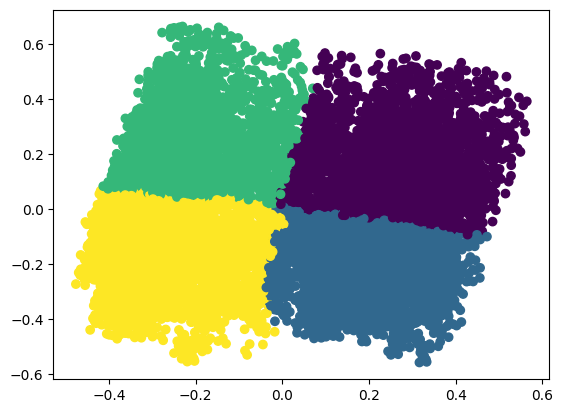

In [8]:
# Calculate the Gower distance matrix
gower_dist_matrix = gower.gower_matrix(X)

# Convert the Gower distance matrix to a similarity matrix
#max_distance = np.max(gower_dist_matrix)
#similarity_matrix = max_distance - gower_dist_matrix

n_clusters_range = range(2, 6)

for n_clusters in n_clusters_range:
        # Obtain cluster labels
        spectral_clustering_model  = SpectralClustering( n_clusters, affinity='nearest_neighbors', random_state=42) 
        y_pred = spectral_clustering_model.fit_predict(X_mca)
        # Calculate Silhouette Score
        silhouette_avg = silhouette_score(gower_dist_matrix
                                            ,y_pred, metric='precomputed') #gower_silhouette_score(X, y_pred)
        print(f"Average Gower Silhouette Score: {silhouette_avg}")
        # Calculate Dunn Index
        dunn_index_score = calculate_dunn_index(gower_dist_matrix, y_pred)
        print(f"Dunn Index: {dunn_index_score}")
        # Calculate Davies-Bouldin Index
        db_index = davies_bouldin_score(X, y_pred) #davies_bouldin_index(X, y_pred)
        print(f"Davies-Bouldin Index: {db_index}")

        # Print contingency matrix 
        
        print(f"Number of Clusters: {np.unique(y_pred).size}")
        print(f"Samples per Cluster: {np.unique(y_pred, return_counts=True)[1]}")
        
        ### Calculate composite score
        # Normalizing Silhouette Score (range [-1, 1] to [0, 1])
        normalized_silhouette = normalize_score(silhouette_avg, -1, 1)

        # Normalizing Dunn Index (Assuming a maximum reasonable value for normalization)
        # This maximum value is an assumption and should be adjusted based on domain knowledge
        max_reasonable_dunn = 0.5  # Example value, adjust based on your data
        davies_bouldin_index = 8
        normalized_dunn = normalize_score(dunn_index_score, 0, max_reasonable_dunn)

        # Normalizing Davies-Bouldin Index (using a logarithmic scale due to high values)
        # We add 1 to avoid log(0) in case of a DB index of 0
        normalized_davies_bouldin = 1 - np.log(1 + db_index) / np.log(1 + max(db_index, davies_bouldin_index))

        # Assuming equal weights for simplicity, but these can be adjusted
        weight_silhouette = 1/3
        weight_dunn = 1/3
        weight_davies_bouldin = 1/3

        # Calculating weighted average
        composite_score_normalized = (weight_silhouette * normalized_silhouette + 
                                    weight_dunn * normalized_dunn + 
                                    weight_davies_bouldin * normalized_davies_bouldin)
        print(f"Composite Score (Normalized): {composite_score_normalized}")
        
        if n_clusters == 4:# Plotting the clusters
                plt.scatter(X_mca.iloc[:, 0], X_mca.iloc[:, 1], c=y_pred, cmap='viridis')
        

In [9]:
spectral_clustering_model  = SpectralClustering(3, affinity='nearest_neighbors', random_state=42) 
y_pred = spectral_clustering_model.fit_predict(X_mca)

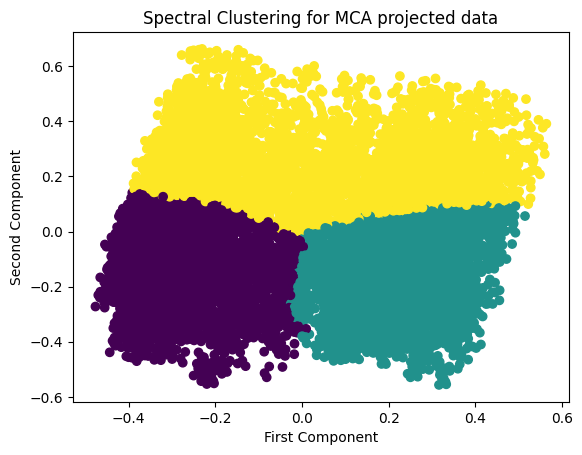

In [12]:
plt.scatter(X_mca.iloc[:, 0], X_mca.iloc[:, 1], c=y_pred, cmap='viridis')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.title('Spectral Clustering for MCA projected data')
plt.show()

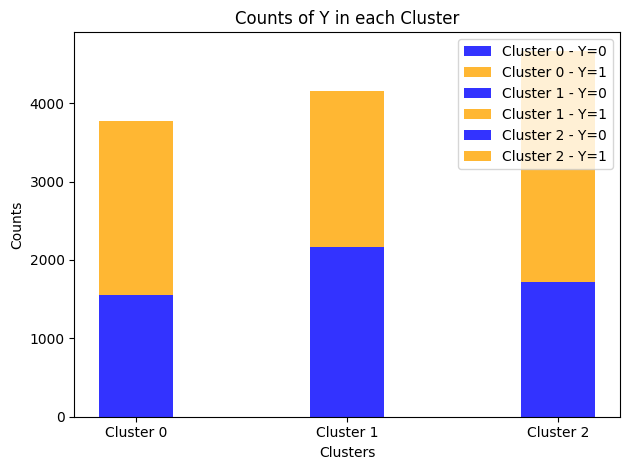

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_split_graph(Y, labels):
    # Calculate the counts for Y=0 and Y=1 in each cluster
    cluster0_Y0 = np.sum((labels == 0) & (Y == 0))
    cluster0_Y1 = np.sum((labels == 0) & (Y == 1))
    cluster1_Y0 = np.sum((labels == 1) & (Y == 0))
    cluster1_Y1 = np.sum((labels == 1) & (Y == 1))
    cluster2_Y0 = np.sum((labels == 2) & (Y == 0))
    cluster2_Y1 = np.sum((labels == 2) & (Y == 1))

    n_groups = 3
    fig, ax = plt.subplots()

    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 0.8

    rects1 = ax.bar(index[0], cluster0_Y0, bar_width,
                    alpha=opacity, color='b',
                    label='Cluster 0 - Y=0')

    rects2 = ax.bar(index[0], cluster0_Y1, bar_width,
                    alpha=opacity, color='orange', bottom=cluster0_Y0,
                    label='Cluster 0 - Y=1')

    rects3 = ax.bar(index[1], cluster1_Y0, bar_width,
                    alpha=opacity, color='b',
                    label='Cluster 1 - Y=0')

    rects4 = ax.bar(index[1], cluster1_Y1, bar_width,
                    alpha=opacity, color='orange', bottom=cluster1_Y0,
                    label='Cluster 1 - Y=1')

    rects5 = ax.bar(index[2], cluster2_Y0, bar_width,
                    alpha=opacity, color='b',
                    label='Cluster 2 - Y=0')

    rects6 = ax.bar(index[2], cluster2_Y1, bar_width,
                    alpha=opacity, color='orange', bottom=cluster2_Y0,
                    label='Cluster 2 - Y=1')

    plt.xlabel('Clusters')
    plt.ylabel('Counts')
    plt.title('Counts of Y in each Cluster')
    plt.xticks(index, ('Cluster 0', 'Cluster 1', 'Cluster 2'))
    plt.legend()

    plt.tight_layout()
    plt.show()



plot_split_graph(y, y_pred)


In [ ]:
df

,TRANSNO,TRLINENO,OWNERNO,LOCNO,EVTSRCTYPE,CRUSERNO,CHUSERNO,EVTLNAME,REASONNO,REASONCODE,...,SYSVALUETYPE_2,COMMENTS_2,CHUSERNO_4,Normal_EVTDTTM,time_diff,current_lifecycle,hour,day,month,is_delivered
0,0,0,23,380,45,647,625,11,3,123,...,0,8,0,2023-12-01 08:12:47,0.000000,1,8,1,12,0
1,0,0,23,380,20,647,625,11,0,107,...,0,8,0,2023-12-01 16:02:10,7.823056,2,16,1,12,0
2,0,0,23,380,6,1017,982,11,84,142,...,0,8,0,2023-12-01 16:02:10,7.823056,3,16,1,12,0
3,0,0,34,528,20,647,625,13,0,107,...,0,13,0,2023-12-01 16:52:41,8.665000,4,16,1,12,0
4,0,0,23,301,55,647,625,47,60,103,...,0,11,0,2023-12-01 20:17:09,12.072778,5,20,1,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17889,999,0,29,55,24,647,625,14,23,119,...,0,4,0,2023-11-22 09:57:46,21.650556,12,9,22,11,1
17890,999,0,29,57,42,647,625,43,95,138,...,0,11,0,2023-11-22 09:58:00,21.654444,13,9,22,11,0
17891,999,0,29,55,42,647,625,7,105,140,...,0,4,0,2023-11-22 09:58:55,21.669722,14,9,22,11,0
17892,999,0,29,55,42,647,625,14,0,107,...,0,4,0,2023-11-22 14:06:00,25.787778,15,14,22,11,1
